# Credit Card Default Prediction Analysis

**Objective**  
This project builds and evaluates machine learning models to predict credit card default using customer demographics, credit limits, and repayment behavior. The primary goal was to identify key risk indicators and compare the performance of different classifiers — with a focus on ensemble models.

**What I Did**
- Preprocessed raw data with categorical encoding and feature engineering  
- Addressed class imbalance using SMOTE  
- Trained and tuned models including Logistic Regression, Random Forest, AdaBoost, XGBoost, LightGBM, and CatBoost  
- Evaluated models using metrics like F1 Score, ROC AUC, confusion matrices, and ROC curves  
- Analyzed feature importance across all tree-based models

**Notebook Sections**
1. About the Data  
2. Libraries and Setup  
3. Data Loading  
4. Feature Engineering  
5. Exploratory Data Analysis  
6. Data Preparation  
7. Logistic Regression Modeling  
8. Tree-Based Model Training  
9. Model Evaluation & Comparison  
10. Feature Importance  
11. Conclusion

![Credit card image](https://imgs.search.brave.com/QcVSsv3myirhZzB4beWXs-4_Na2D4v_pAsDn-LoUhNs/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5pc3RvY2twaG90/by5jb20va)


## 1. About the Data

**Overview:**  
This dataset includes demographic details, credit history, bill statements, and payment records of credit card clients in Taiwan, spanning April to September 2005.

**Features:**

  **Demographics**
  - **ID**: Client identifier  
  - **LIMIT_BAL**: Credit limit (NT dollars)  
  - **SEX**: Gender (1 = Male, 2 = Female)  
  - **EDUCATION**: Education level  
  - 1 = Graduate school  
  - 2 = University  
  - 3 = High school  
  - 4 = Others  
  - 5, 6 = Unknown  
  - **MARRIAGE**: Marital status (1 = Married, 2 = Single, 3 = Others)  
  - **AGE**: Age in years  

  **Payment History**
  - **PAY_0 to PAY_6**: Repayment status for each month (April–September 2005)  
  - -1 = Paid in full  
  - 0 = Revolving credit  
  - 1–8 = Delay in months (8 = Eight or more months)  

  **Bill & Payment Amounts**
  - **BILL_AMT1 to BILL_AMT6**: Monthly bill amounts (NT dollars)  
  - **PAY_AMT1 to PAY_AMT6**: Monthly payments made (NT dollars)  

  **Target**
  - **default.payment.next.month**: Default in next month (1 = Yes, 0 = No)

**Time Period:**
- **Start**: April 2005  
- **End**: September 2005  

**Source:**
Collected from Taiwanese credit card clients.  [Dataset on Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data)


## 2. Libraries and Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Additional utilities
from scipy.stats import randint, uniform, loguniform
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 3. Data Loading

**Note:** Update the file path to match your local dataset location.

In [2]:
# Load the data
df = pd.read_csv(
    "../Data/UCI_Credit_Card.csv"
)

# Clean up column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace(".", "_")

In [3]:
# Display data shape
print("\nDataset Overview:")
print(f"Shape: {df.shape}")


Dataset Overview:
Shape: (30000, 25)


In [4]:
# Display first few rows
df.head()


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
# Display basic statistics
df.describe().round(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,...,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,...,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47,0.42
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,...,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7500.75,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,...,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75,0.00
50%,15000.50,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,...,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00,0.00
75%,22500.25,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,...,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,...,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00


In [6]:
# Check for missing values
print(df.isnull().sum().any())

False


In [7]:
# Display data types
df.dtypes

id                              int64
limit_bal                     float64
sex                             int64
education                       int64
marriage                        int64
age                             int64
pay_0                           int64
pay_2                           int64
pay_3                           int64
pay_4                           int64
pay_5                           int64
pay_6                           int64
bill_amt1                     float64
bill_amt2                     float64
bill_amt3                     float64
bill_amt4                     float64
bill_amt5                     float64
bill_amt6                     float64
pay_amt1                      float64
pay_amt2                      float64
pay_amt3                      float64
pay_amt4                      float64
pay_amt5                      float64
pay_amt6                      float64
default_payment_next_month      int64
dtype: object

## 4. Feature Engineering

**Key Transformations:**
- Cleaned and encoded categorical variables (`education`, `marriage`, `sex`, and `pay_n`).
- Engineered features capturing payment behavior trends, max delay, and monthly credit utilization.


In [8]:
# Process categorical variables 
education_map = {
    0: 0,  # Unknown
    1: 1,  # Graduate School
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Others
    5: 0,  # Unknown
    6: 0,  # Unknown
}
df["education_cat"] = df["education"].map(education_map).astype("category")

df["marriage_cat"] = df["marriage"].astype("category")# 0: Unknown, 1: Married, 2: Single, 3: Other

df["sex_cat"] = df["sex"].astype("category")  # 1: Male, 2: Female

# Drop original categorical variables
df = df.drop(columns=["education", "marriage", "sex"])

# Convert PAY_# status columns to category (keeping numeric values)
for n in np.arange(0, 7):
    if n != 1:
        df[f"pay_{n}"] = df[f"pay_{n}"].astype("category")

In [9]:
# Derived Features

# Payment delay trend (linear slope)
pay_cols = [f"pay_{n}" for n in np.arange(0, 7) if n != 1]
df["payment_delay_trend"] = df[pay_cols].apply(
    lambda x: np.polyfit(range(len(x)), x.astype(float), 1)[0], axis=1
)

# Maximum payment delay
df["max_payment_delay"] = df[pay_cols].astype(float).max(axis=1)

# Credit utilization ratios
for n in np.arange(1, 7):
    df[f"utilization_ratio_{n}"] = df[f"bill_amt{n}"] / df["limit_bal"].replace(0, np.nan)

In [10]:
# Check for missing values
print("\nCheck for missing values:")
print(df.isnull().sum().any())

# Check final data shape
print("\nData shape:")
print(df.shape)


Check for missing values:
False

Data shape:
(30000, 33)


## 5. Exploratory Data Analysis<a name="eda"></a>

- Visualized target variable distribution and computed the default rate.
- Calculated and visualized correlation matrices for categorical and numerical features.
- Identified top correlated variables with the target.
- Analyzed default rates across demographic variables: education, marriage, gender, and age.
- Plotted credit limit distribution overall and by default status.


In [11]:
# Define feature types
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCheck all columns are captured:")
df.shape[1] == len(cat_cols) + len(num_cols)



Check all columns are captured:


True

### 5.1 Class Distribution & Imbalance Handling

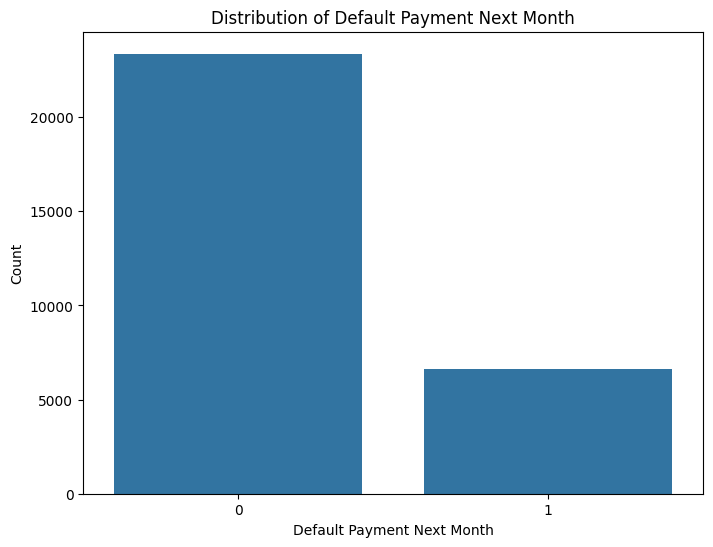


Overall default rate: 22.12%


In [12]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="default_payment_next_month", data=df)
plt.title("Distribution of Default Payment Next Month")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Count")
plt.show()

default_rate = df["default_payment_next_month"].value_counts(normalize=True)[1].round(4)
print(f"\nOverall default rate: {default_rate*100}%")

The target variable `Default Payment Next Month` is imbalanced, with a default rate of **22.12%**. Most observations belong to class `0` (no default), while class `1` (default) is underrepresented.

To address this imbalance during model training, I will apply **SMOTE** (Synthetic Minority Over-sampling Technique) to oversample the minority class.


### 5.2 Key Correlations Analysis

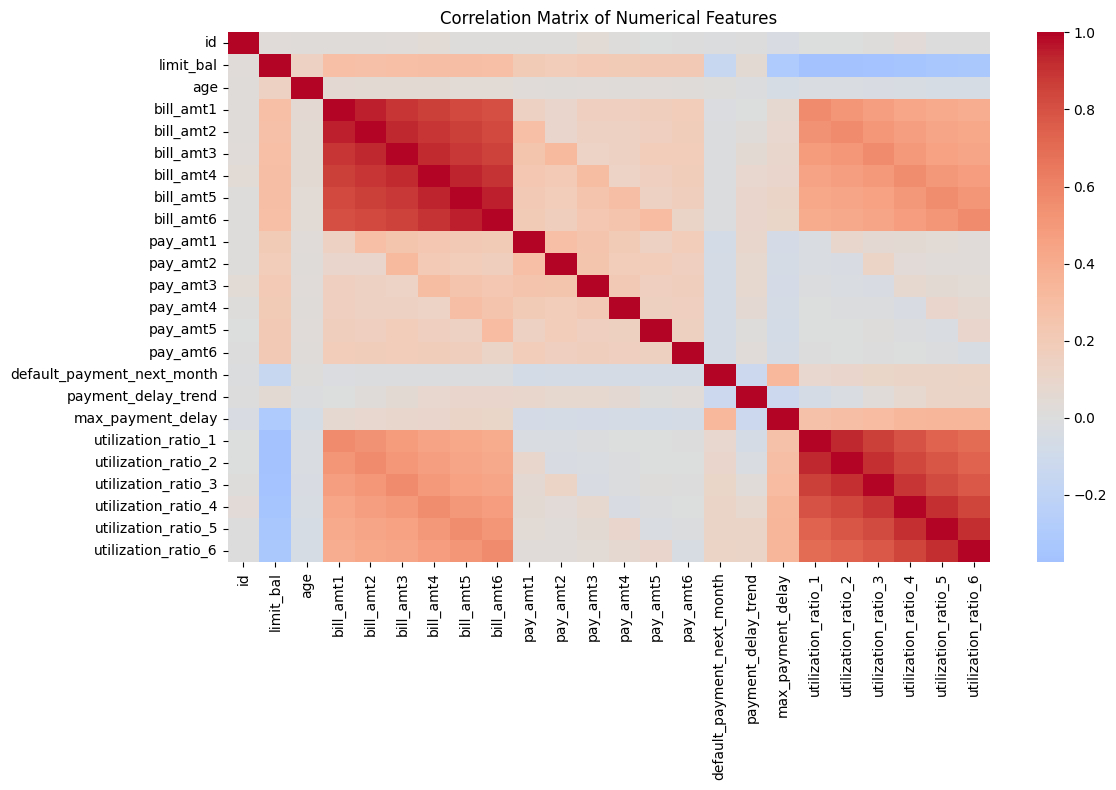


Top correlations of numerical features with default payment next month:
0.33 for max_payment_delay
0.15 for limit_bal
0.13 for payment_delay_trend
0.12 for utilization_ratio_6
0.12 for utilization_ratio_5


In [14]:
# Correlation analysis with numerical features
plt.figure(figsize=(12, 8))
num_corr_matrix = df[num_cols].corr()
sns.heatmap(num_corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# Find top correlations with target
top_corr_vars = (
    num_corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .index[1:6]  
)
top_corr_vals = (
    num_corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .iloc[1:6]  
    .round(2)
)
print("\nTop correlations of numerical features with default payment next month:")
for var, val in zip(top_corr_vars, top_corr_vals):
    print(f"{val} for {var}")


**Numerical Features Correlation Insights:**
- **Bill Amounts** and **Utilization Ratios** are strongly correlated across adjacent months, indicating stable credit usage patterns over time.
- Strong positive correlation exists between **Bill Amounts** and **Utilization Ratios**, reflecting higher utilization with higher bills.
- Top correlations with `Default Payment Next Month`:
  - `max_payment_delay`: **0.33**
  - `limit_bal`: **-0.15** (inverse: lower credit limits linked to higher default risk)
  - `payment_delay_trend`: **0.13**
  - `utilization_ratio_5–6`: **0.12**

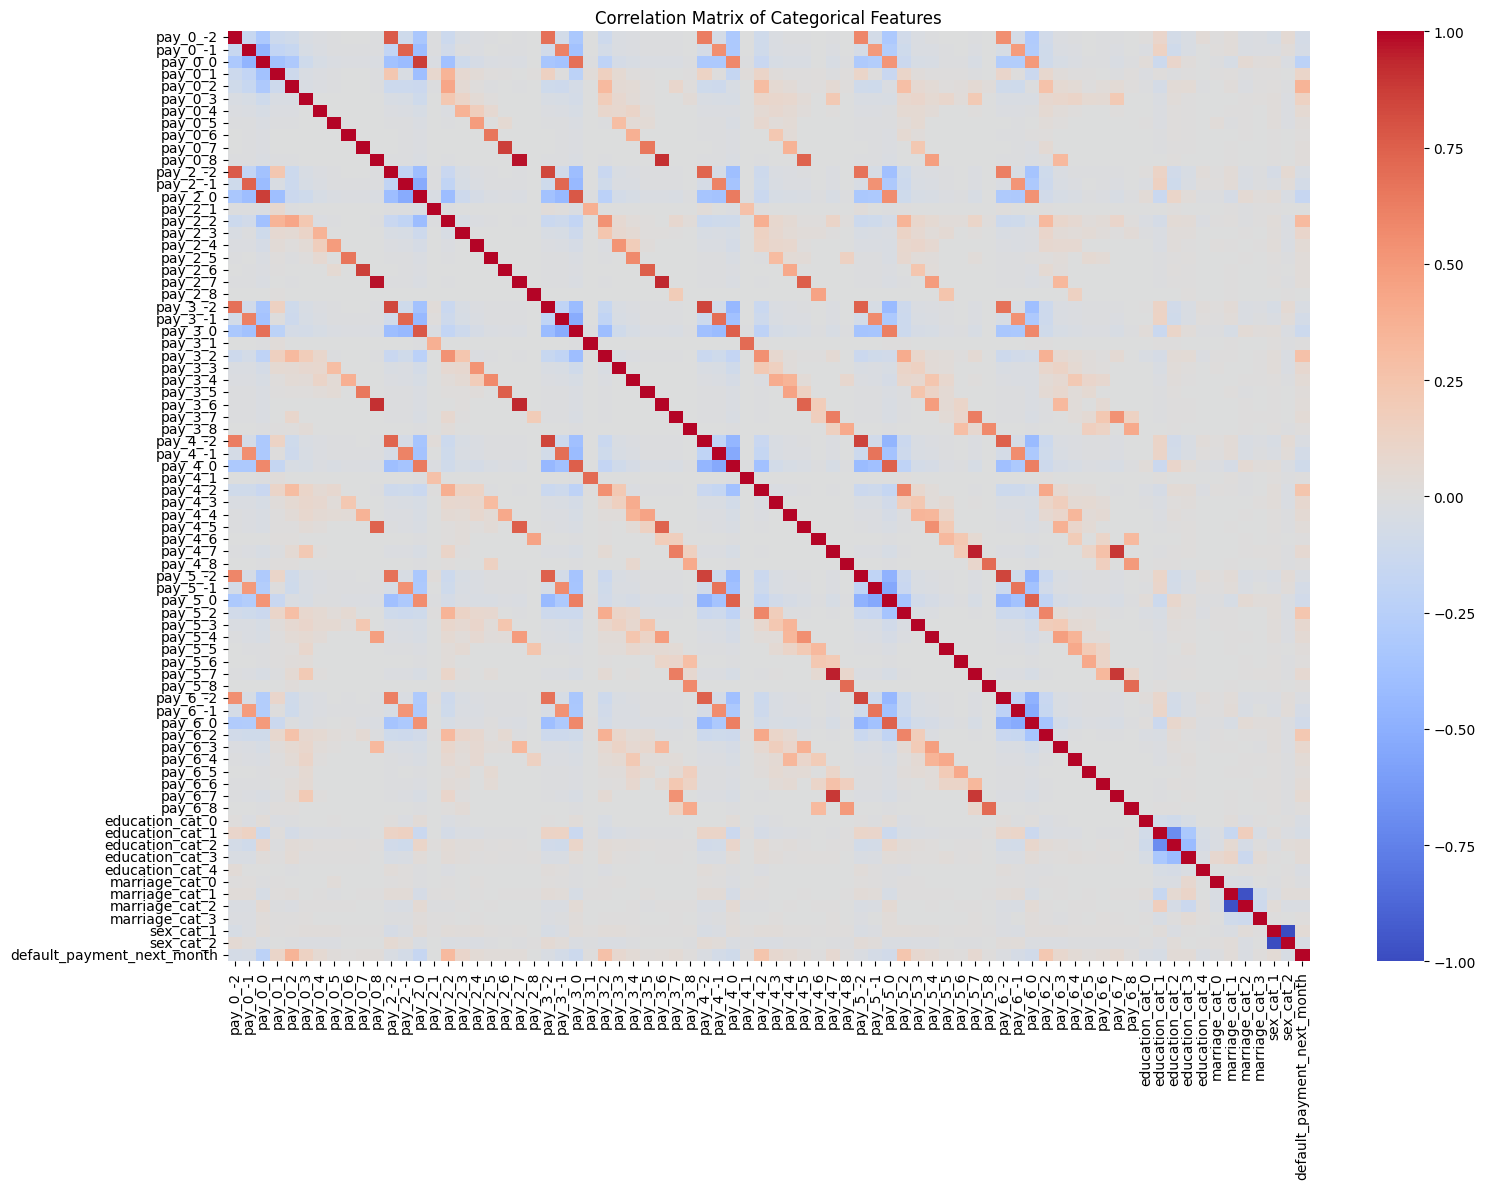


Top correlations of catgorical features with default payment next month:
0.35 for pay_0_2
0.31 for pay_2_2
0.27 for pay_3_2
0.25 for pay_4_2
0.24 for pay_5_2


In [15]:
# Correlation analysis with categorical features
plt.figure(figsize=(16, 12))

# Convert categorical columns to numeric for correlation analysis
cat_df = pd.get_dummies(df[cat_cols])
cat_df["default_payment_next_month"] = df["default_payment_next_month"]

# Calculate correlation matrix
cat_corr_matrix = cat_df.corr()

# Calculate correlation matrix
sns.heatmap(
    cat_corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0,
    xticklabels=True,
    yticklabels=True
)

plt.title("Correlation Matrix of Categorical Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find top correlations with target
top_corr_vars = (
    cat_corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .index[1:6]  
)
top_corr_vals = (
    cat_corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .iloc[1:6]  
    .round(2)
)
print("\nTop correlations of catgorical features with default payment next month:")
for var, val in zip(top_corr_vars, top_corr_vals):
    print(f"{val} for {var}")

**Categorial Features Correlation Insights:**
- Recent payment status variables show the strongest correlation with default:
  - `pay_0_2`: **0.35**
  - `pay_2_2`: **0.31**
  - `pay_3_2`, `pay_4_2`, `pay_5_2`: **0.24 – 0.27**
- Early on-time payments (e.g., `pay_0_0`, `pay_2_0`) have **negative** correlation with default, highlighting the importance of recent payment behavior.
- Demographic variables (e.g., age, sex, education, marriage) show weak correlations.

### 5.3 Default Rate by Demographics


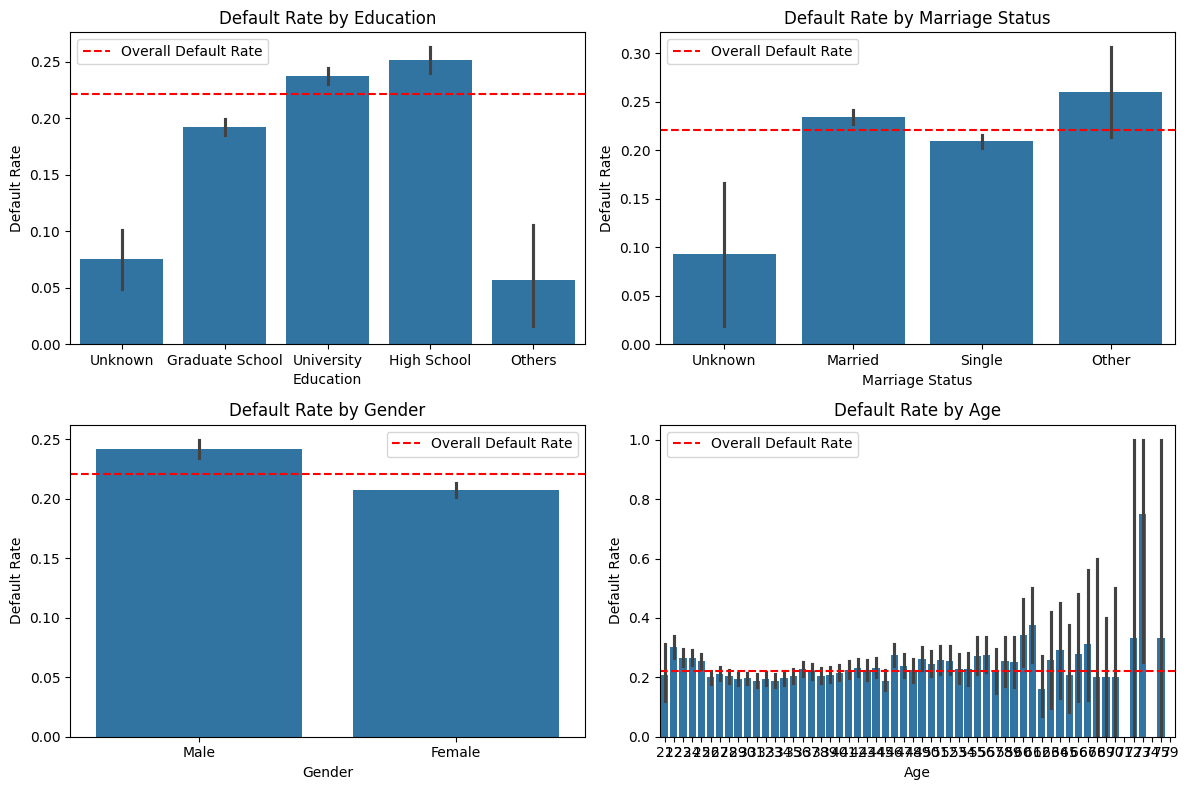

In [16]:
# Demographic analysis 
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Mapping x-axis labels
education_labels = ["Unknown", "Graduate School", "University", "High School", "Others"]
marriage_labels = ["Unknown", "Married", "Single", "Other"]
sex_labels = ["Male", "Female"]
age_labels = ["18-25", "26-35", "36-45", "46-55", "55+"]

# Education
sns.barplot(x="education_cat", y="default_payment_next_month", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Default Rate by Education")
axes[0, 0].set_xlabel("Education")
axes[0, 0].set_ylabel("Default Rate")
axes[0, 0].set_xticklabels(education_labels)
axes[0, 0].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[0, 0].legend()

# Marriage
sns.barplot(x="marriage_cat", y="default_payment_next_month", data=df, ax=axes[0, 1])
axes[0, 1].set_title("Default Rate by Marriage Status")
axes[0, 1].set_xlabel("Marriage Status")
axes[0, 1].set_ylabel("Default Rate")
axes[0, 1].set_xticklabels(marriage_labels)
axes[0, 1].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[0, 1].legend()

# Gender
sns.barplot(x="sex_cat", y="default_payment_next_month", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Default Rate by Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Default Rate")
axes[1, 0].set_xticklabels(sex_labels)
axes[1, 0].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[1, 0].legend()

# Age
sns.barplot(x="age", y="default_payment_next_month", data=df, ax=axes[1, 1])
axes[1, 1].set_title("Default Rate by Age")
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Default Rate")
axes[1, 1].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


**Demographic Insights:**

- **Education**: Default rates are higher among high school and university graduates; graduate school borrowers default less. "Others"/"Unknown" categories show low rates but may be unreliable.
- **Marriage**: Singles default slightly less than married individuals; the "Other" group shows the highest default rate.
- **Gender**: Males have a higher default rate than females.
- **Age**: Highest default rates are in the 18–25 and 55+ groups; lowest in the 26–35 range.

While weakly correlated, demographic features may still add value for segmentation or interaction effects in modeling.


### 5.4 Credit Limit Distribution Analysis


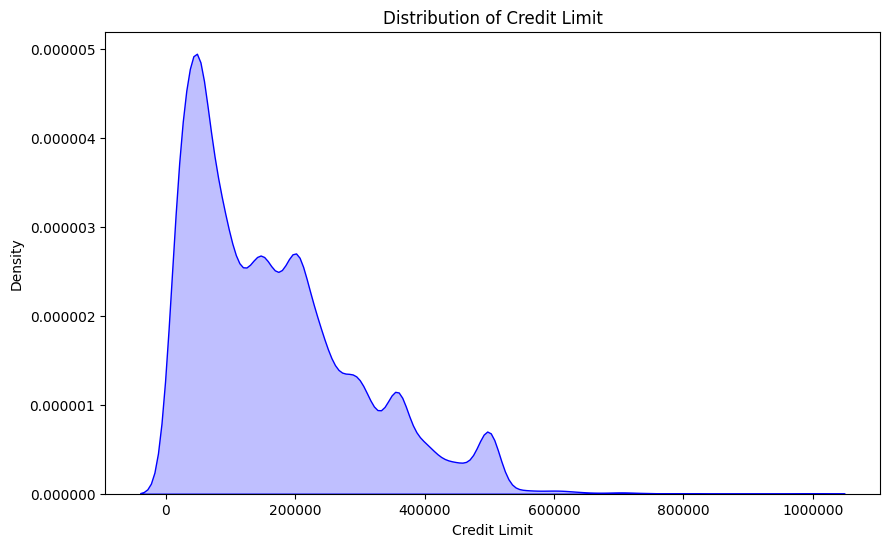

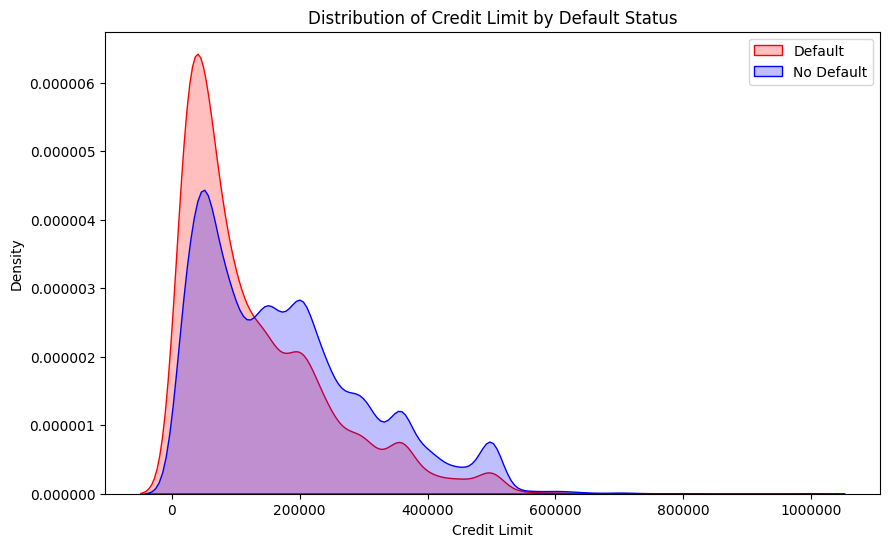

In [17]:
# Credit limit analysis
plt.figure(figsize=(10, 6))
sns.kdeplot(df["limit_bal"], color="blue", shade=True)
plt.title("Distribution of Credit Limit")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
plt.ticklabel_format(style="plain", axis="both", useOffset=False)
plt.show()

# Credit limit by default status
plt.figure(figsize=(10, 6))
plt.title("Distribution of Credit Limit by Default Status")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
sns.kdeplot(
    df[df["default_payment_next_month"] == 1]["limit_bal"],
    color="red",
    shade=True,
    label="Default",
)
sns.kdeplot(
    df[df["default_payment_next_month"] == 0]["limit_bal"],
    color="blue",
    shade=True,
    label="No Default",
)
plt.ticklabel_format(style="plain", axis="both", useOffset=False)
plt.legend()
plt.show()

- The **overall distribution of credit limits** is heavily right-skewed, with most customers having a limit between **0 and 200,000**, and very few exceeding **500,000**. This suggests a concentration of lower-credit-limit customers in the dataset.

- When segmented by **default status**, we observe that:
  - Customers who **defaulted** tend to have **lower credit limits**, with their density peaking earlier and declining faster.
  - Customers who **did not default** have a **broader distribution**, with a higher share extending into higher credit limit ranges.

This pattern supports the correlation analysis, which showed a **negative correlation (~0.15)** between `limit_bal` and the likelihood of default—i.e., lower credit limits are somewhat associated with higher default risk.

## 6. Data Preparation

- Split data into training and test sets using stratified sampling (80/20 split).
- Applied **SMOTE** on the training set to oversample the minority class and balance the target distribution.

In [39]:
# Data preparation
X = df.drop(columns=["default_payment_next_month", "id"])
y = df["default_payment_next_month"]

num_cols = [col for col in num_cols if col not in ['id', 'default_payment_next_month']]

# Split data into train+val and test first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [44]:
# Oversampling with SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

In [45]:
# Check resampled data shape and distribution
print("\nResampled data shape:")
print(X_train_resampled.shape)
print(y_train_resampled.value_counts(normalize=True))


Resampled data shape:
(37382, 31)
default_payment_next_month
0    0.5
1    0.5
Name: proportion, dtype: float64


## 7. Logistic Regression Modeling

- Built a pipeline with scaling, encoding, and logistic regression.
- Tuned `C` and `penalty` using RandomizedSearchCV (F1 scoring).

**F1 score** as the evaluation metric balances **precision** (avoiding false positives) and **recall** (capturing defaults), which is critical in imbalanced classification problems like credit default prediction.


In [46]:
# Define a dictionary to store the best models
best_models = {}

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [47]:
# Define preprocessor     
log_reg_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Logistic Regression pipeline
log_reg_pipeline = ImbPipeline([
    ("preprocess", log_reg_preprocessor),
    ("clf", LogisticRegression(solver="saga", max_iter=1000, random_state=RANDOM_STATE)),
])

# Hyperparameter space
log_reg_param_grid = {
    "clf__C": loguniform(1e-3, 10),
    "clf__penalty": ["l1", "l2"],
}

# RandomizedSearchCV
log_reg_cv = RandomizedSearchCV(
    estimator=log_reg_pipeline,
    param_distributions=log_reg_param_grid,
    n_iter=15,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit model
print("Training Logistic Regression...")
start_time = time.time()

log_reg_cv.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
duration = end_time - start_time

# Store results
best_models["Logistic Regression"] = {
    "best_estimator": log_reg_cv.best_estimator_,
    "training_time_seconds": duration,
    "best_params": log_reg_cv.best_params_,
    "best_f1_score": log_reg_cv.best_score_,
}

print(f"Done. Best f1 score: {log_reg_cv.best_score_:.4f} | Training Time: {duration:.1f}s")

Training Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Done. Best f1 score: 0.8713 | Training Time: 155.6s


In [48]:
# Logistic Regression Results
y_pred = log_reg_cv.predict(X_test)
y_pred_proba = log_reg_cv.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Results:")
print(f"Best Parameters: {best_models['Logistic Regression']['best_params']}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Logistic Regression Results:
Best Parameters: {'clf__C': 0.24810409748678125, 'clf__penalty': 'l1'}
Accuracy: 0.8180
Precision: 0.6612
Recall: 0.3632
F1: 0.4689
ROC AUC: 0.7610


**Logistic Regression results:** While the model shows strong precision, its recall is relatively low, indicating it misses a fair number of actual defaults. Lets try try to improve this using decision tree based models.


## 8. Tree-Based Model Training

- Configured and tuned five classifiers: **Random Forest**, **AdaBoost**, **XGBoost**, **LightGBM**, and **CatBoost** using `RandomizedSearchCV` with F1 scoring.
- Applied appropriate preprocessing for tree models, **Ordinal Encoding**.


In [49]:
# Preprocess
tree_preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
], remainder="passthrough")

In [51]:
# Model configurations
model_configs = {
    "Random Forest": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", RandomForestClassifier(
                random_state=RANDOM_STATE, 
                class_weight="balanced", 
                n_jobs=-1
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(5, 20),
            "clf__min_samples_split": randint(2, 10),
            "clf__min_samples_leaf": randint(1, 5),
        },
    },
    "AdaBoost": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    max_depth=1,
                    random_state=RANDOM_STATE,
                    class_weight="balanced"
                ),
                random_state=RANDOM_STATE
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(50, 200),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__estimator__max_depth": randint(1, 5),
        },
    },
    "XGBoost": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                eval_metric="logloss",
                use_label_encoder=False,
                enable_categorical=False,  
                verbosity=0
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__subsample": uniform(0.7, 0.3),
            "clf__scale_pos_weight": loguniform(1, 10),
        },
    },
    "LightGBM": {
        "pipeline": ImbPipeline([
            ("clf", lgb.LGBMClassifier(
                random_state=RANDOM_STATE,
                eval_metric="binary_logloss",
                categorical_features=cat_cols,
                verbose=-1
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__num_leaves": randint(20, 50),
        },
    },
    "CatBoost": {
        "pipeline": ImbPipeline([
            ("clf", CatBoostClassifier(
                random_state=RANDOM_STATE,
                eval_metric="Logloss",
                cat_features=cat_cols,
                verbose=0,
            ))
        ]),
        "tuning_params": {
            "clf__iterations": randint(100, 300),
            "clf__depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
        },
    },
}


In [52]:
# Train and tune models
for model_name, config in model_configs.items():
    print(f"\nTraining and tuning {model_name}...")

    start_time = time.time()

    search = RandomizedSearchCV(
        estimator=config["pipeline"],
        param_distributions=config["tuning_params"],
        n_iter=15,
        cv=kf,
        scoring="f1",
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
    )

    search.fit(X_train, y_train)

    end_time = time.time()
    duration = end_time - start_time

    best_models[model_name] = {
        "best_estimator": search.best_estimator_,
        "training_time_seconds": duration,
        "best_params": search.best_params_,
        "best_f1_score": search.best_score_,
    }

    print(f"{model_name} done. Best F1: {search.best_score_:.4f} | Time: {duration:.1f}s")



Training and tuning Random Forest...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Forest done. Best F1: 0.5423 | Time: 47.1s

Training and tuning AdaBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
AdaBoost done. Best F1: 0.5345 | Time: 40.5s

Training and tuning XGBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBoost done. Best F1: 0.5390 | Time: 15.0s

Training and tuning LightGBM...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
LightGBM done. Best F1: 0.4791 | Time: 21.3s

Training and tuning CatBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CatBoost done. Best F1: 0.4757 | Time: 191.4s


## 9. Model Evaluation & Comparison

- Evaluated all tuned models on the test set using **accuracy, precision, recall, F1 score, ROC AUC**, and **training time**.
- Plotted confusion matrices and ROC curves for each model.
- Compiled a summary table for side-by-side comparison of model performance.


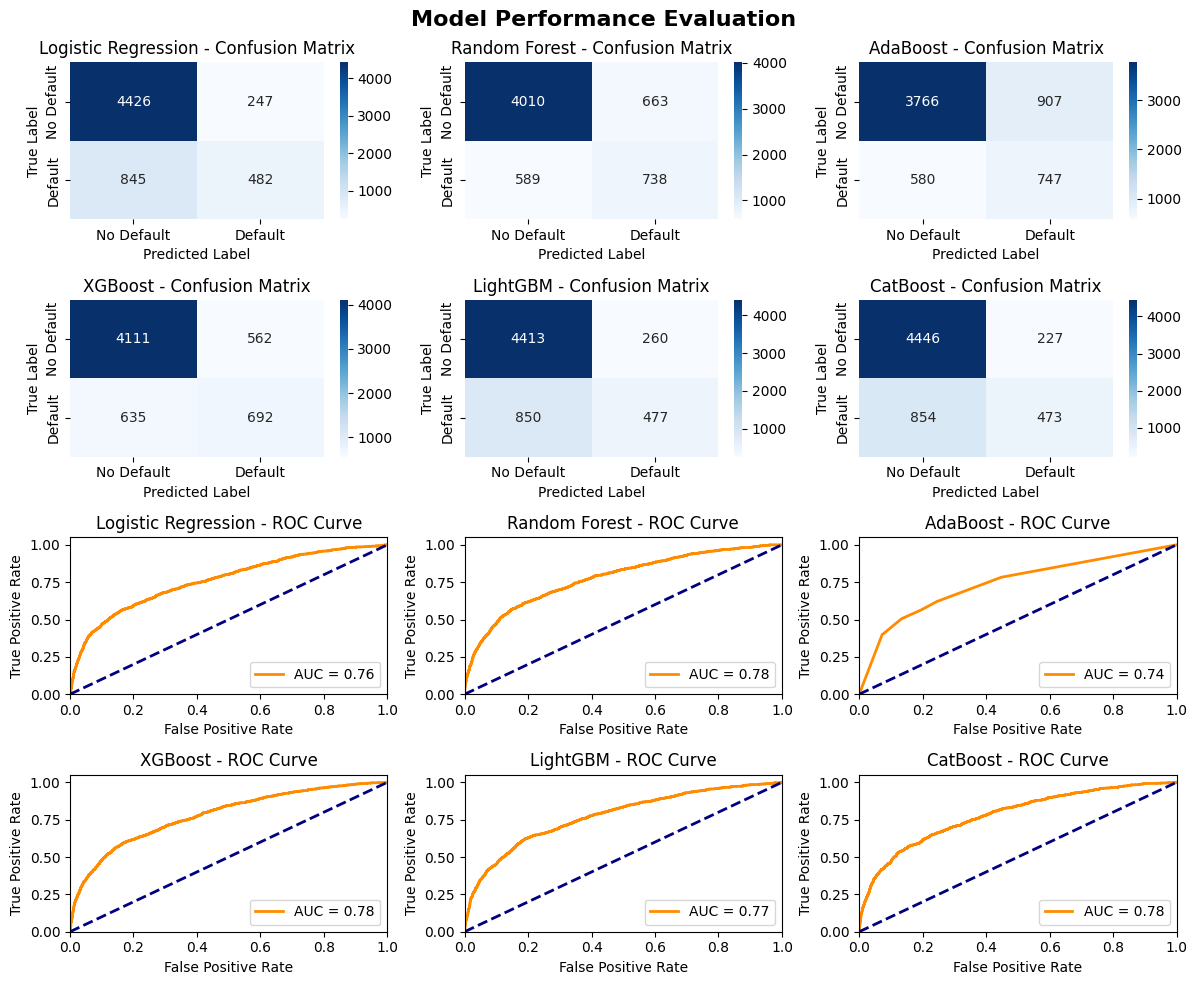


 Model Comparison Summary Table:
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC | Training Time   |
|:--------------------|-----------:|------------:|---------:|-----------:|----------:|:----------------|
| Logistic Regression |     0.818  |      0.6612 |   0.3632 |     0.4689 |    0.761  | 2 min 35 sec    |
| Random Forest       |     0.7913 |      0.5268 |   0.5561 |     0.5411 |    0.7766 | 0 min 47 sec    |
| AdaBoost            |     0.7522 |      0.4516 |   0.5629 |     0.5012 |    0.7391 | 0 min 40 sec    |
| XGBoost             |     0.8005 |      0.5518 |   0.5215 |     0.5362 |    0.7792 | 0 min 14 sec    |
| LightGBM            |     0.815  |      0.6472 |   0.3595 |     0.4622 |    0.7739 | 0 min 21 sec    |
| CatBoost            |     0.8198 |      0.6757 |   0.3564 |     0.4667 |    0.7811 | 3 min 11 sec    |


In [53]:
# Results summary
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
fig.suptitle("Model Performance Evaluation", fontsize=16, fontweight='bold')

axes = axes.flatten()

metrics_summary = []

for idx, (model_name, model_info) in enumerate(best_models.items()):
    model = model_info["best_estimator"]
    
    predictions = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, pred_proba)

    total_seconds = model_info["training_time_seconds"]
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    training_time = f"{minutes} min {seconds} sec"

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "Training Time": training_time
    })

    # confusion matrix
    cm = confusion_matrix(y_test, predictions)

    sns.heatmap(
        cm,
        annot=True, 
        fmt="d",
        cmap="Blues",
        xticklabels=["No Default", "Default"],
        yticklabels=["No Default", "Default"],
        ax=axes[idx]
    )
    axes[idx].set_title(f"{model_name} - Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

    # ROC curve
    roc_idx = idx + len(best_models)
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    axes[roc_idx].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    axes[roc_idx].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axes[roc_idx].set_xlim([0.0, 1.0])
    axes[roc_idx].set_ylim([0.0, 1.05])
    axes[roc_idx].set_xlabel("False Positive Rate")
    axes[roc_idx].set_ylabel("True Positive Rate")
    axes[roc_idx].set_title(f"{model_name} - ROC Curve")
    axes[roc_idx].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Create and display summary DataFrame
df_metrics = pd.DataFrame(metrics_summary)
print("\n Model Comparison Summary Table:")
print(df_metrics.to_markdown(index=False))


**Model Comparison Summary:**

- **Random Forest** had the best F1 (0.5411) and recall, making it the most balanced for identifying defaulters.
- **XGBoost** offered strong overall performance with high ROC AUC (0.7792) and fast training.
- **LightGBM** and **CatBoost** showed high precision but poor recall, limiting their usefulness when catching defaulters is critical.
- **AdaBoost** had the highest recall but lowest precision and accuracy, over-predicting defaults.
- **Logistic Regression** underperformed on recall and F1 despite SMOTE, showing its limits in imbalanced settings.

Interestingly, models that natively handled or explicitly emphasized categorical variables - **CatBoost**, **LightGBM**, and **Logistic Regression (with OHE)** - all showed **lower recall**, suggesting they were less effective at identifying defaulters. In contrast, models using **ordinal encoding** (e.g., Random Forest, XGBoost, AdaBoost) achieved **higher recall**, possibly due to smoother handling of ordinal relationships and better generalization from limited minority-class patterns. This highlights a potential trade-off between preserving category structure and capturing rare-event signals in imbalanced data.



## 10. Feature Importance<a name="feature-importance"></a>


Logistic Regression: Feature importance not available.



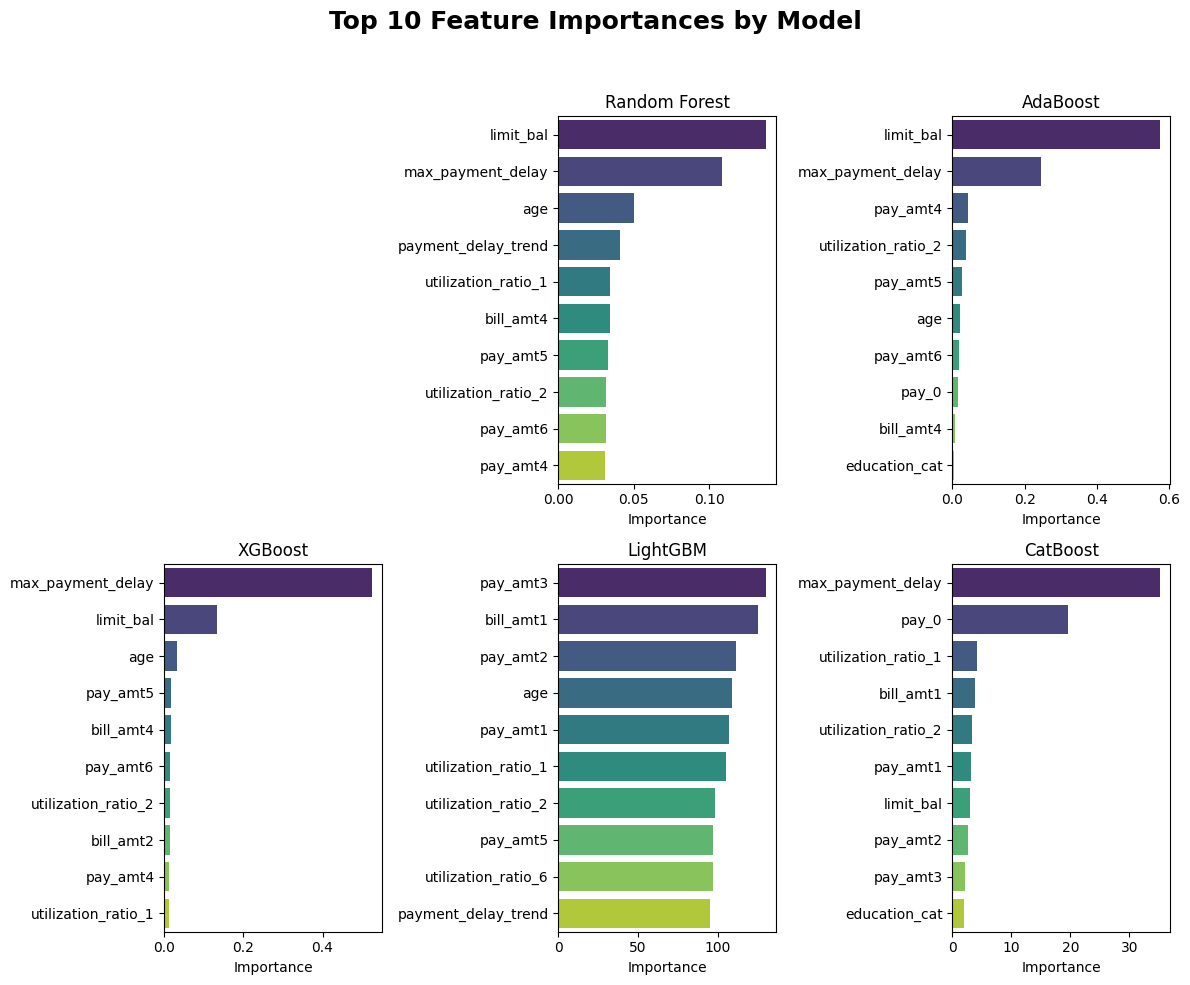

In [55]:
# Simple Feature Importance Plot for Supported Models
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()
fig.suptitle("Top 10 Feature Importances by Model", fontsize=18, fontweight='bold')

for idx, (model_name, model_info) in enumerate(best_models.items()):
    if idx >= len(axes):
        break

    model = model_info["best_estimator"]

    # Get classifier from pipeline
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") else model

    if not hasattr(clf, "feature_importances_"):
        print(f"{model_name}: Feature importance not available.\n")
        fig.delaxes(axes[idx])
        continue

    importances = clf.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(len(importances))]

    # Get top 10 features
    indices = np.argsort(importances)[-10:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Plot
    sns.barplot(x=top_importances, y=top_features, ax=axes[idx], palette="viridis")
    axes[idx].set_title(model_name)
    axes[idx].set_xlabel("Importance")
    axes[idx].set_ylabel("")

# Remove extra subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Feature Importance Insights:**

- **Max Payment Delay** and **Limit Balance** are consistently ranked among the most important features across all models, confirming their strong predictive power.
- **Age** and **Utilization Ratios** (especially months 1–2) appear frequently, indicating credit usage patterns and borrower age are useful for distinguishing defaulters.
- **Payment Delay Trend** is influential in models like Random Forest and LightGBM, highlighting the value of capturing payment behavior over time.
- **Payment Amounts** (e.g., `pay_amt3`, `pay_amt5`) and **Bill Amounts** show moderate importance, particularly in boosting models.
- Categorical features (e.g., `education_cat`, `pay_0`) were only weakly important, with limited impact on most models.
- **CatBoost** and **LightGBM**, which handle categorical features natively, still prioritize numeric variables — suggesting structured numeric features dominate in this dataset.

Overall, models heavily rely on repayment history, credit limits, and usage behavior rather than demographic or categorical fields.


## 11. Conclusion

This project developed machine learning models to predict credit card default using customer and payment behavior data. Compared to random guessing (which would yield an F1 score near **0.22**, equal to the base default rate), all trained models performed significantly better, with the best models—**Random Forest** and **XGBoost**—achieving F1 scores above **0.53** and ROC AUC scores near **0.78**. These models effectively captured key risk signals such as **payment delays**, **credit limit**, and **credit utilization**. While demographic and categorical features added minimal direct value, ensemble models handled complex patterns well, offering strong potential for real-world credit risk screening.
